# Emotion-Semantic Mapping through Wikipedia Article Transitions

This notebook investigates the interplay between semantic shifts and emotional fluctuations as users navigate through Wikipedia articles. The goal is to understand how changes in content affect emotional responses during reading. Our approach begins by calculating semantic distances between consecutive articles using various text embeddings and distance measures, followed by clustering to identify the optimal metric for minimal bias. Next, we employ an emotion prediction model to assign 26 types of emotion scores to each navigation step, adjusting scores to account for reading behavior, such as increased attention on hyperlinks. Finally, we analyze correlations between semantic distance and emotion scores, exploring whether significant semantic shifts provoke specific emotional responses. This study aims to uncover patterns in how users emotionally respond to content transitions, providing insights into human cognitive and affective processing during online navigation.

#### Environment Setup

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Add custom module path
import sys
sys.path.append("./src/semantic")

# Standard library imports
import re

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorsys

# Semantic analysis scripts
from src.semantic.perform_clustering import (
    run_all_clustering, 
    run_kimchi_cos,
    run_all_clustering_with_pca
)
from src.semantic.utils.evaluate_clustering import (
    calculate_clustering_consistency,
    get_primary_category,
    map_clustering_category,
)

# Emotion analysis scripts
from src.emotion.emotion_utils import (
    preprocess_text, 
    extract_text_from_html, 
    extract_sentences, 
    generate_link_freq_dict, 
    extract_path_data
)
from src.emotion.emotion_scores import (
    calculate_weighted_emotion_for_single_path, 
    process_backtracking_paths
)
from src.emotion.emotion_visualization import (
    plot_link_frequencies, 
    plot_emotion_paths, 
    calculate_emotion_correlation
)

## Explore Different Measures of Semantic Distance

### Text Embedding

To quantify the distances between webpages, we generated text embeddings for articles using three pre-trained models: `All_MiniLM_L6_v2`, `all_mpnet_base_v2`, and `Roberta`. The implementation is in the `generate_embeddings.py` file.

#### Properties of the Generated Embeddings

1. **Dimensionality**  
   - Each embedding is a fixed-size vector (e.g., 384 dimensions for `All_MiniLM_L6_v2` or 768 for `Roberta`), regardless of the article length. The dimensionality depends on the chosen model.

2. **Context Awareness**  
   - These embeddings are context-sensitive. For example, the word "bank" will have different embeddings based on whether the article discusses "riverbanks" or "financial institutions."

3. **Semantic Similarity**  
   - Articles with similar content will have embeddings that are closer in vector space. For example, articles about "climate change" and "global warming" will have more similar embeddings than articles about "machine learning."

4. **Pre-trained Knowledge**  
   - The models used are pre-trained on large text corpora, which allows them to capture general language patterns and semantic relationships.

5. **Scalability**  
   - The embeddings are compact and can be efficiently used for large-scale downstream tasks like clustering or search.

6. **Model-Specific Strengths**:
   - **`All_MiniLM_L6_v2`**: Optimized for efficiency, producing high-quality embeddings with relatively low computational cost.
   - **`all_mpnet_base_v2`**: Balances semantic understanding and contextual accuracy.
   - **`Roberta`**: Provides more sophisticated contextual embeddings, especially useful for nuanced language understanding.

---

#### Why These Embeddings Matter

The generated embeddings allow us to:
- Measure semantic relationships between articles using mathematical metrics (e.g., cosine similarity).
- Group similar articles together or identify patterns across texts.
- Prepare data for more complex tasks like topic modeling, sentiment analysis, or recommendation systems.

By saving these embeddings, the script ensures that this rich semantic information can be reused without re-processing the text, saving computational resources for future analyses.

In [15]:
# Path to the category data file
category_file = './/data//wikispeedia//wikispeedia_paths-and-graph//categories.tsv'

# All paths to the embedding data files
MiniLM_file = './/data//semantic//output//embeddings//all_MiniLM_L6_v2.pkl' 
mpnet_file = './/data//semantic//output//embeddings//all_mpnet_base_v2.pkl' 
roberta_file = './/data//semantic//output//embeddings//roberta.pkl' 

## Semantic Measure Evaluation: Clustering on Embeddings

#### Why Perform Clustering?

Clustering groups semantically similar articles based on their embeddings, enabling validation and analysis. It helps:
- **Semantic Grouping**: Ensures articles with similar content are accurately grouped.
- **Metric Evaluation**: Identifies the optimal distance metric for clustering with minimal bias.
- **Category Validation**: Verifies if embeddings reflect predefined categories.
- **Downstream Applications**: Supports visualization, trend analysis, and recommendations.

---

#### Overview of the Clustering Process

1. **Load Embeddings**: Embeddings representing articles are read from a file.  
2. **Define Clusters**: The number of clusters is determined by the unique categories in the dataset.  
3. **Clustering Methods**:
   - **K-Means**: Efficient, assumes spherical clusters.
   - **K-Medoids**: Flexible with Manhattan or Cosine distance metrics.
   - **Spectral Clustering**: Suitable for non-linearly separable data.
4. **Dimensionality Reduction**: Optional PCA reduces embedding dimensions to improve clustering efficiency.  
5. **Cluster Details**: Extracts cluster centers, sizes, and member articles for interpretation.  
6. **Save Results**: Clusters are stored for reuse in analysis or downstream tasks.

---

#### Why Multiple Methods?

Using various clustering techniques (K-Means, K-Medoids, Spectral Clustering) ensures flexibility and robustness. Each method highlights different aspects of data structure, enabling better alignment with the dataset's unique characteristics.

In [16]:
# For embeddings generated from MiniLM
print('------Starting clustering for embeddings based on MiniLM_L6_v2...')
MiniLM_clustering = run_all_clustering(MiniLM_file, category_file)
print(f"Perform {list(MiniLM_clustering.keys())} successfully!")

# For embeddings generated from mpnet_base_v2
print('------Starting clustering for embeddings based on mpnet_base_v2...')
mpnet_clustering = run_all_clustering(mpnet_file, category_file)
print(f"Perform {list(mpnet_clustering.keys())} successfully!")

# Cluster embeddings generated from roberta
print('------Starting clustering for embeddings based on roberta...')
roberta_clustering = run_all_clustering(roberta_file, category_file)
print(f"Perform {list(roberta_clustering.keys())} successfully!")

------Starting clustering for embeddings based on MiniLM_L6_v2...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!
------Starting clustering for embeddings based on mpnet_base_v2...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:17<00:00,  4.40s/it]


Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!
------Starting clustering for embeddings based on roberta...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:26<00:00,  6.53s/it]

Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!


the clustering results is stored as follows:

- **MiniLM_clustering**
  - **K-Means**: Embeddings (DataFrame)
  - **K-Medoids Manhattan**: Embeddings (DataFrame)
  - **K-Medoids Cosine**: Embeddings (DataFrame)
  - **Spectral Clustering NN**: Embeddings (DataFrame)

In [17]:
# A sample of clustering results
MiniLM_clustering['K-Means'].head(5)

,concept,clustering
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,4
1,%C3%85land,9
2,%C3%89douard_Manet,8
3,%C3%89ire,4
4,%C3%93engus_I_of_the_Picts,4


### Methods for Evaluating Clustering Consistency

To assess clustering consistency, two key metrics are used:

#### **Adjusted Rand Index (ARI)**
- **Measures**: Pairwise consistency between two clustering results.
- **Range**: [-1, 1]
  - **1**: Perfect agreement.
  - **0**: Agreement by chance.
  - **-1**: Perfect disagreement.
- **Strength**: Adjusts for chance, ensuring fairness across varying cluster counts.

#### **Normalized Mutual Information (NMI)**
- **Measures**: Shared information between two clustering results.
- **Range**: [0, 1]
  - **1**: Perfect alignment.
  - **0**: No shared information.
- **Strength**: Robust to varying cluster sizes and distributions.

---

### Why ARI and NMI?

- **ARI** captures pairwise grouping accuracy.
- **NMI** evaluates overall structural alignment.  
Using both ensures a well-rounded evaluation of clustering consistency.

In [18]:
# Extract clustering results from each DataFrame's 'clustering' column and store in a list
MiniLM_list = [df['clustering'].tolist() for df in MiniLM_clustering.values()]
mpnet_list = [df['clustering'].tolist() for df in mpnet_clustering.values()]
roberta_list = [df['clustering'].tolist() for df in roberta_clustering.values()]

# Calculate average clustering consistency for each embedding
MiniLM_ari, MiniLM_nmi = calculate_clustering_consistency(MiniLM_list)
mpnet_ari, mpnet_nmi = calculate_clustering_consistency(mpnet_list)
roberta_ari, MiniLM_nmi = calculate_clustering_consistency(roberta_list)

# Show the result 
clustering_consistency = pd.DataFrame({
    'Average ARI': [MiniLM_ari, mpnet_ari, roberta_ari],
    'Average NMI': [MiniLM_nmi, mpnet_nmi, MiniLM_nmi]
})
clustering_consistency.index = ['MiniLM', 'mpnet', 'roberta']

clustering_consistency

,Average ARI,Average NMI
MiniLM,0.189281,0.318860
mpnet,0.164385,0.366222
roberta,0.167638,0.318860


**Observations:**
- **Embeddings generated by mpnet** shows the highest scores for both Average ARI (0.147835) and Average NMI (0.317228), indicating the best consistency and stability among the models.

### Category-Cluster Mapping and Accuracy Evaluation


- This method calculates the accuracy and weighted F1 score for the Category-Cluster Mapping. 
- First, the cluster-category mapping is sorted in descending order based on their mapping counts and then uniquely matched (each cluster corresponds to only one category, and each category corresponds to only one cluster).
- **Accuracy** is calculated as the proportion of matched articles in the Category-Cluster Mapping out of all articles. 
- **Weighted F1 score** accounts for the varying sizes of different categories, providing a more comprehensive evaluation of the clustering results.


In [19]:
# Get primary categories for concepts and show the head
primary_category = get_primary_category(category_file)
primary_category.head(5)

,concept,primary_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People
2,%C3%85land,Countries
3,%C3%85land,Geography
4,%C3%89douard_Manet,People


In [20]:
# Set dicts to save the mapping results
MiniLM_evaluation = {}
mpnet_evaluation = {}
roberta_evaluation = {}

# Set df to save the evaluation results
MiniLM_eva_df = pd.DataFrame(columns=['accuracy','weighted_F1'])
mpnet_eva_df = pd.DataFrame(columns=['accuracy','weighted_F1'])
roberta_eva_df = pd.DataFrame(columns=['accuracy','weighted_F1'])

# evaluation on MiniLM_L6_v2
print("------Evaluation results for MiniLM embeddings:")
for key, value in MiniLM_clustering.items():
    cluster_category_mapping, accuracy, weighted_f1 = map_clustering_category(primary_category, value)
    MiniLM_evaluation[key] = cluster_category_mapping
    MiniLM_eva_df.loc[len(MiniLM_eva_df)] = [accuracy, weighted_f1]
MiniLM_eva_df.index = ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN']
print(MiniLM_eva_df)

# evaluation on mpnet_base_v2
print("------Evaluation results for mpnet embeddings:")
for key, value in mpnet_clustering.items():
    cluster_category_mapping, accuracy, weighted_f1 = map_clustering_category(primary_category, value)
    mpnet_evaluation[key] = cluster_category_mapping
    mpnet_eva_df.loc[len(mpnet_eva_df)] = [accuracy, weighted_f1]
mpnet_eva_df.index = ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN']
print(mpnet_eva_df)

# evaluation on mpnet_base_v2
print("------Evaluation results for roberta embeddings:")
for key, value in roberta_clustering.items():
    cluster_category_mapping, accuracy, weighted_f1 = map_clustering_category(primary_category, value)
    roberta_evaluation[key] = cluster_category_mapping
    roberta_eva_df.loc[len(roberta_eva_df)] = [accuracy, weighted_f1]
roberta_eva_df.index = ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN']
print(roberta_eva_df)


------Evaluation results for MiniLM embeddings:
                        accuracy  weighted_F1
K-Means                 0.308417     0.363921
K-Medoids_Manhattan     0.261337     0.306894
K-Medoids_Cosine        0.263259     0.306203
Spectral_Clustering_NN  0.368370     0.383479
------Evaluation results for mpnet embeddings:
                        accuracy  weighted_F1
K-Means                 0.381630     0.428639
K-Medoids_Manhattan     0.277287     0.318159
K-Medoids_Cosine        0.295158     0.332416
Spectral_Clustering_NN  0.346272     0.336160
------Evaluation results for roberta embeddings:
                        accuracy  weighted_F1
K-Means                 0.303613     0.351552
K-Medoids_Manhattan     0.257686     0.270871
K-Medoids_Cosine        0.222905     0.261829
Spectral_Clustering_NN  0.418332     0.402913


**Observations:**
- Among all embedding models, mpnet shows the highest degree of alignment with the original primary categories.

### Evaluation of different embeddings by comparing a clustering to the primary categories 

#### Method
We use **k-medoids clustering** with **cosine distance** to group the embeddings. The number of clusters is set to match the number of unique primary categories in the dataset.

#### Motivations
- **Cosine Distance**: Normalizes embedding vectors by comparing their directional similarity, ensuring that variations in article length do not influence clustering results.
- **K-Medoids**: Selects actual data points as cluster centers, allowing us to interpret clusters by analyzing the names and primary categories of these representative points, which serve as the most central elements of each cluster.

In [21]:
category_df = pd.read_csv(category_file, sep='\t', skiprows=12, header=None)
category_df.columns = ['concept','category']
category_df['primary_category'] = category_df['category'].apply(lambda x: x.split('.')[1])
category_dict = dict(zip(category_df['concept'], category_df['primary_category']))

models = ['all_MiniLM_L6_v2', 'all_mpnet_base_v2', 'roberta']

model_clustering_dfs = []
for model_name in models:
    model_file = f'.//data//semantic//output//embeddings//{model_name}.pkl'
    model_cluster = run_kimchi_cos(model_file, category_file)
    model_cluster['center_category'] = model_cluster['center_name'].map(category_dict)
    model_cluster['members_categories'] = model_cluster['member_names'].apply(
        lambda members: [category_dict.get(member, 'Unknown') for member in members]
    )
    model_clustering_dfs.append(model_cluster)


for i, clustering_df in enumerate(model_clustering_dfs): 
    print(models[i])
    print(clustering_df[['center_name', 'center_category', 'cluster_size']])

15 categories found in wikispeedia.
15 categories found in wikispeedia.
15 categories found in wikispeedia.
all_MiniLM_L6_v2
                   center_name center_category  cluster_size
0               Elephant_shrew         Science           531
1                Protoceratops         Science           142
2                   Dimetrodon         Science           159
3                     Devonian       Geography           193
4                    Stone_Age         History           227
5                      Geology       Geography           422
6                  Mesopotamia         History           256
7                      Assyria         History           294
8                      Biology         Science           432
9                        Earth         Science           320
10             Akkadian_Empire         History           376
11  History_of_the_Netherlands         History           385
12                 8th_century         History           304
13                   

**Observations** 
Most of the cluster centers are related to Science. This is not very surprinsing because, science is the biggest primary category : 

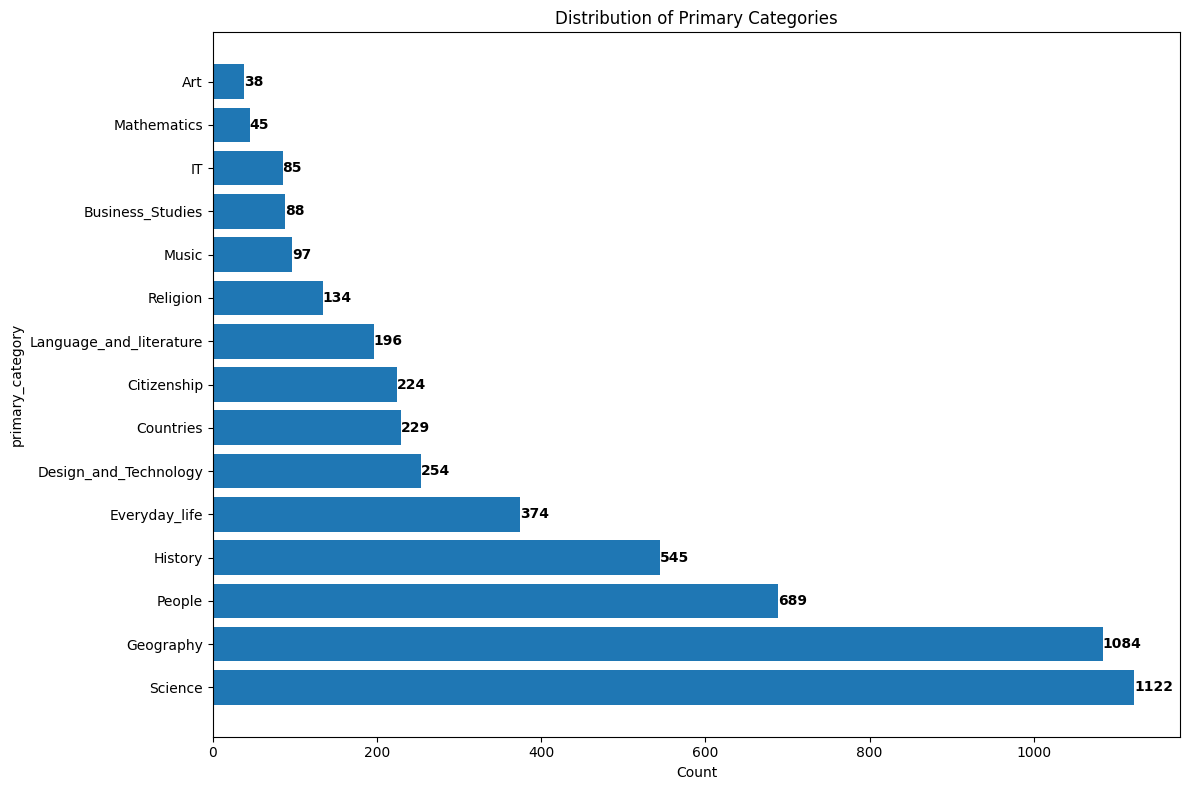

In [22]:
def plot_distribution(df, column, title=None, figsize=(12, 8), top_n=None, sort_by='value'):
    """
    Plot the distribution of values in a specified column of a DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - column: str, the name of the column to plot
    - title: str, optional, the title of the plot
    - figsize: tuple, optional, the size of the figure (width, height)
    - top_n: int, optional, limit to top N categories (by frequency or alphabetically)
    - sort_by: str, optional, 'value' to sort by frequency (default) or 'index' to sort alphabetically
    """
    value_counts = df[column].value_counts()
    if sort_by == 'index':
        value_counts = value_counts.sort_index()
    if top_n is not None:
        value_counts = value_counts.nlargest(top_n) if sort_by == 'value' else value_counts.head(top_n)

    plt.figure(figsize=figsize)
    bars = plt.barh(value_counts.index, value_counts.values)
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                 ha='left', va='center', fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.title(title or f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

plot_distribution(category_df, 'primary_category', title='Distribution of Primary Categories')


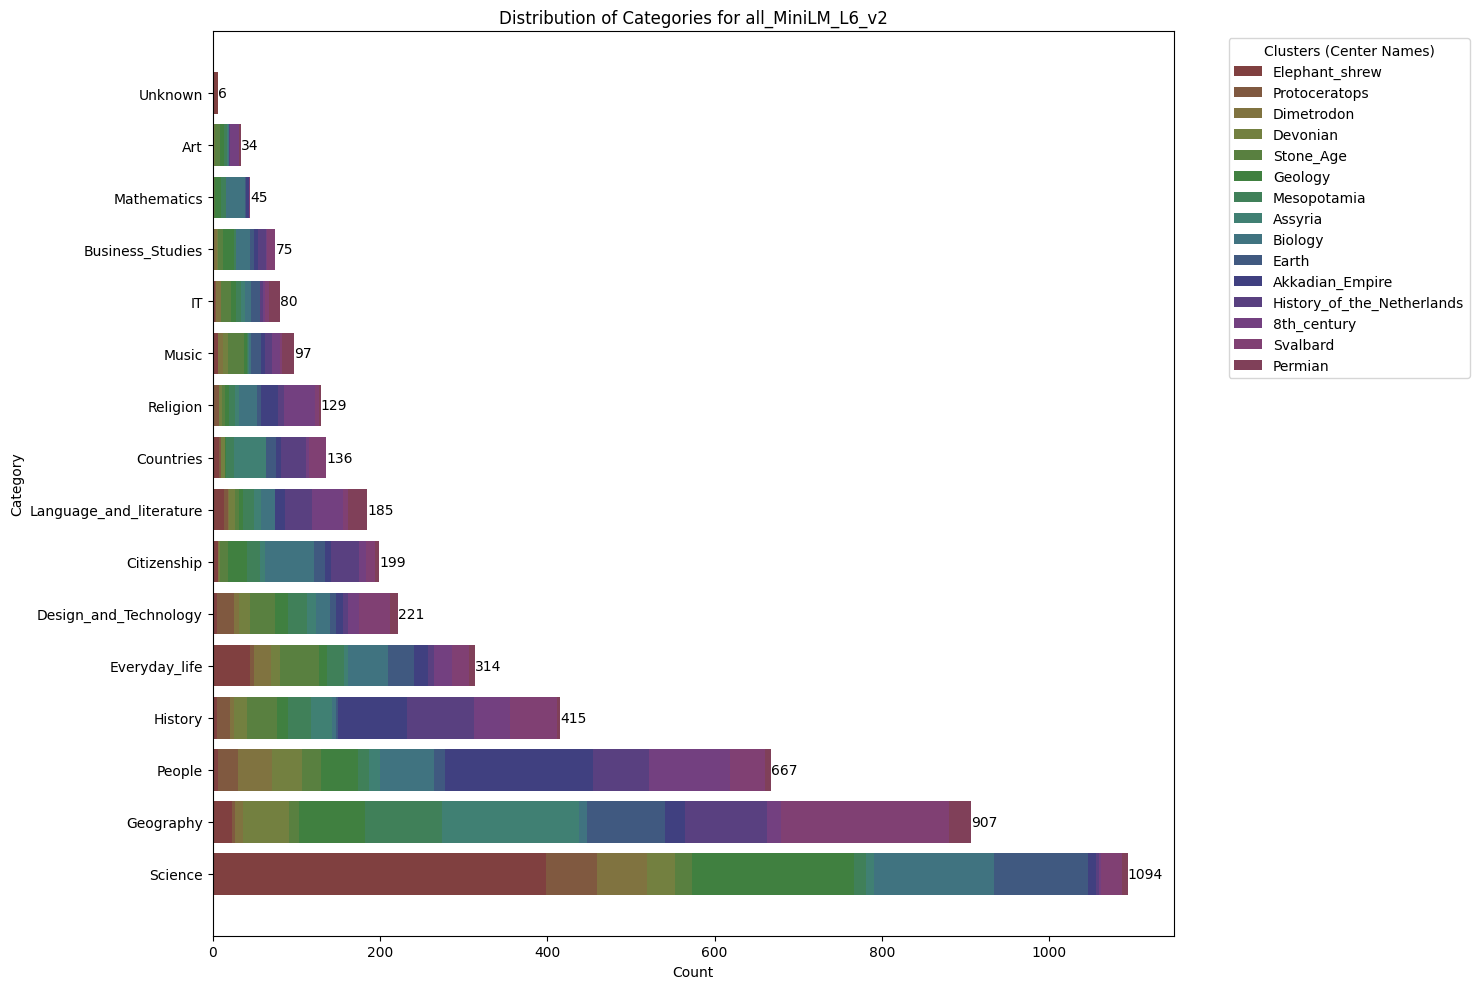

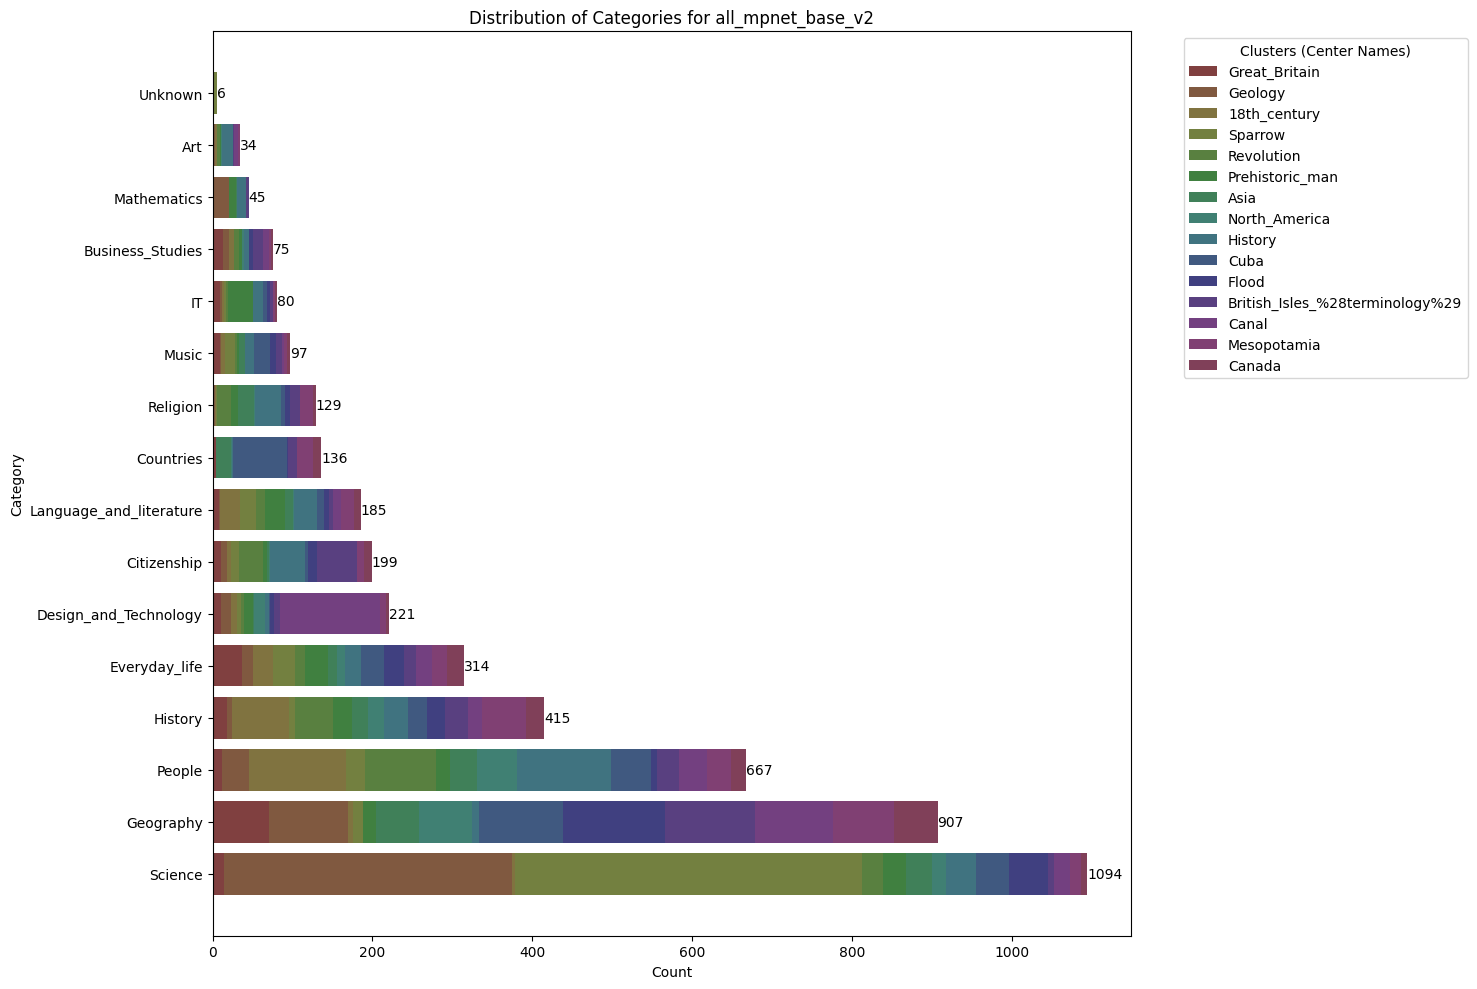

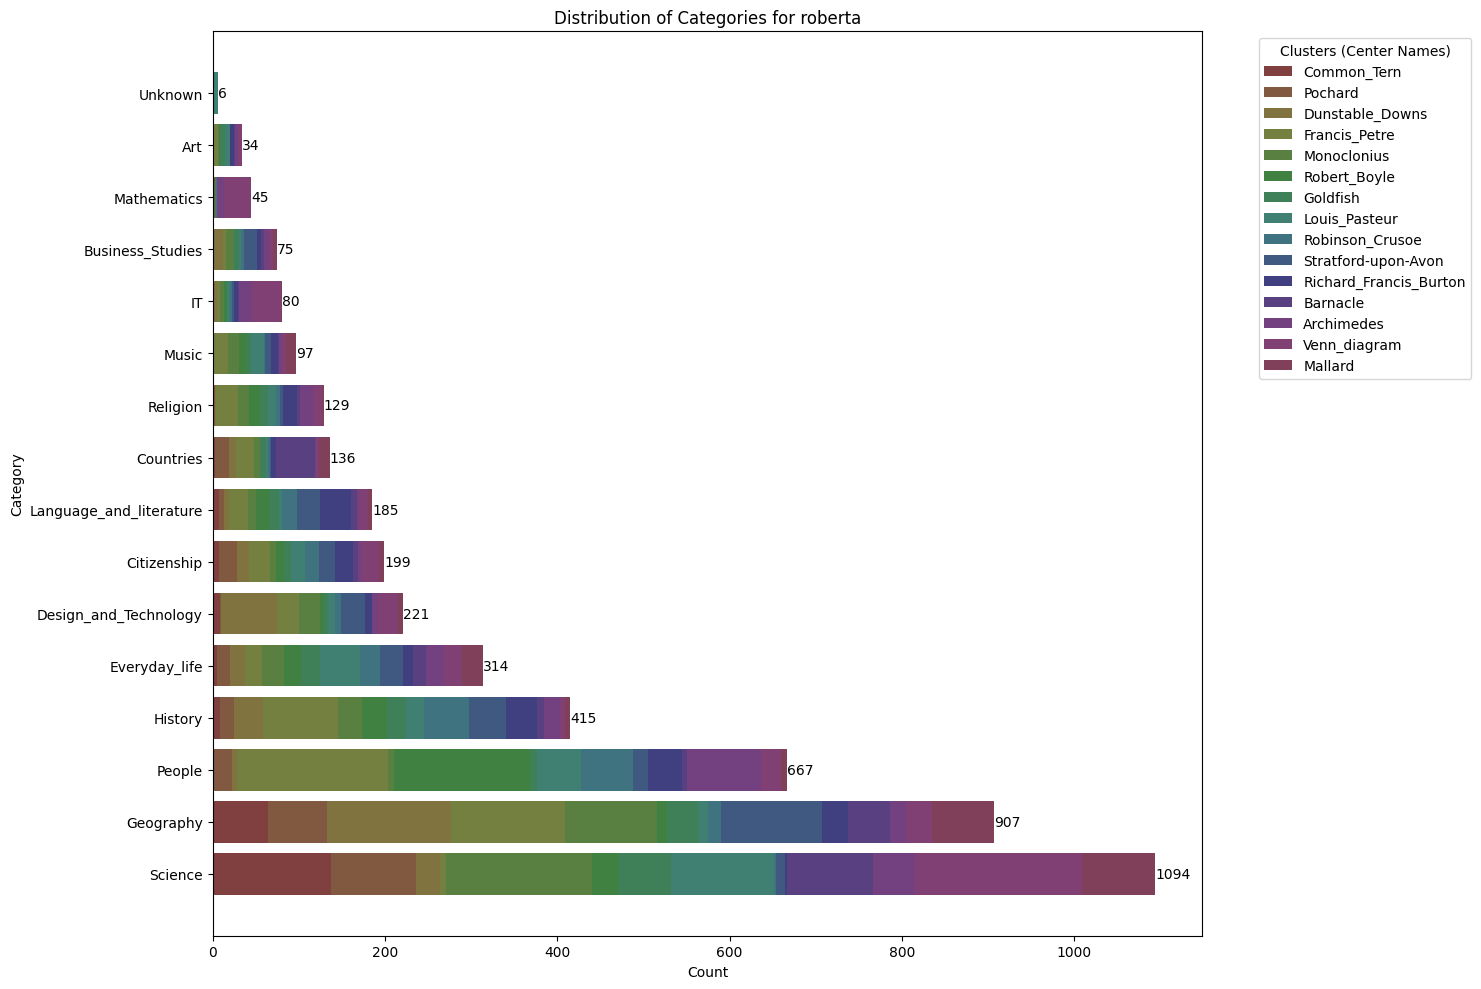

In [23]:
def plot_distribution_stacked(df, column, members_column, title=None, figsize=(15, 10)):
    """
    Plot the distribution of values with each cluster having a unique color,
    sorted by total count and using center_name for cluster labels.
    
    Parameters:
    - df: pandas DataFrame with clustering results
    - column: str, column containing center categories
    - members_column: str, column containing lists of member categories
    - title: str, optional title for the plot
    - figsize: tuple, size of the figure
    """
    # Flatten member categories and count occurrences
    all_categories = df[members_column].explode().value_counts().index
    
    # Generate a color palette with a distinct color for each cluster
    def generate_distinct_colors(n):
        HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
        return list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    colors = generate_distinct_colors(len(df))
    
    # Prepare the plot
    plt.figure(figsize=figsize)
    
    # Track the bottom of each bar for stacking
    bottom = np.zeros(len(all_categories))
    
    # Plot each cluster with a different color
    for i, (_, row) in enumerate(df.iterrows()):
        center_name = row['center_name']
        member_categories = row[members_column]
        
        # Count category occurrences for this cluster
        category_counts = pd.Series(member_categories).value_counts()
        
        # Create a bar for each category in this cluster
        cluster_bars = []
        for cat in all_categories:
            count = category_counts.get(cat, 0)
            bar = plt.barh(cat, count, left=bottom[all_categories.get_loc(cat)], 
                           color=colors[i], label=center_name)
            cluster_bars.append(bar)
            bottom[all_categories.get_loc(cat)] += count
    
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.title(title or 'Distribution of Categories Across Clusters')
    
    # Add count labels
    for cat_idx, cat in enumerate(all_categories):
        plt.text(bottom[cat_idx], cat_idx, f'{bottom[cat_idx]:.0f}', 
                 va='center', ha='left')
    
    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Clusters (Center Names)', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Usage
for i, model_cluster in enumerate(model_clustering_dfs):
    plot_distribution_stacked(model_cluster, 'center_category', 'members_categories', 
                      title=f'Distribution of Categories for {models[i]}')


The diversity of colors within each bar shows that articles from the same primary category are spread across multiple clusters. For instance, articles in the Science and Geography categories are dispersed across various clusters, as indicated by the range of colors in those bars.

The clustering results reveal a rich mix of categories within each cluster, indicating that the model captures semantic relationships across topics rather than restricting articles to predefined categories. This suggests that clustering based on embeddings can uncover nuanced connections between articles beyond traditional category boundaries, which can be beneficial for identifying cross-disciplinary themes and insights.

### Dealing with High Dimensionality of Embeddings: PCA

The embeddings generated by models like Roberta are high-dimensional, often containing hundreds of features. This high dimensionality can lead to challenges in clustering, as it increases computational requirements and can introduce noise, making it harder to identify meaningful groupings.

**Why Use PCA?**
- **Dimensionality Reduction**: Principal Component Analysis (PCA) reduces the number of features in the embeddings while retaining the most important information. By projecting the data onto a lower-dimensional space, PCA helps streamline clustering and other analyses.
- **Noise Reduction**: In high-dimensional spaces, embeddings may contain redundant or less relevant information. PCA captures the principal components—the directions with the most variance—reducing irrelevant noise and making clusters more distinct.
- **Improved Clustering Efficiency**: Lower-dimensional data is faster and less computationally intensive to process. PCA thus enhances the efficiency of clustering algorithms, enabling more effective grouping of articles.

Using PCA on embeddings makes it easier to reveal meaningful structures and relationships within the data, allowing clusters to more accurately reflect semantic similarities across articles.

15 categories found in wikispeedia.


100%|██████████| 4/4 [00:10<00:00,  2.69s/it]


15 categories found in wikispeedia.


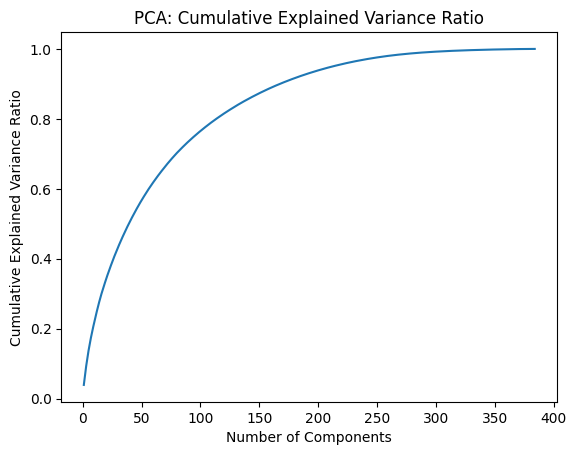

Number of components explaining 95.0% of variance: 213


100%|██████████| 4/4 [00:10<00:00,  2.60s/it]


15 categories found in wikispeedia.


100%|██████████| 4/4 [00:17<00:00,  4.27s/it]


15 categories found in wikispeedia.


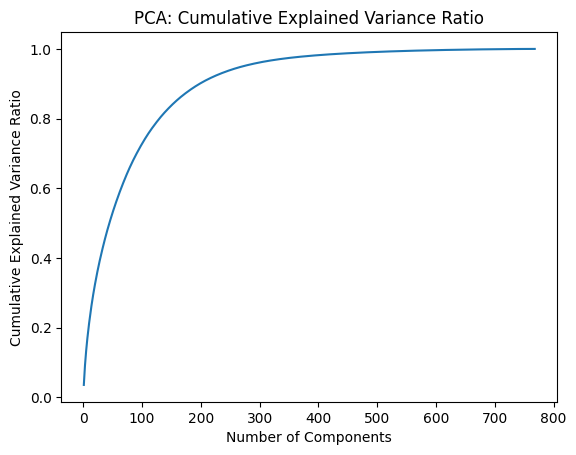

Number of components explaining 95.0% of variance: 272


100%|██████████| 4/4 [00:17<00:00,  4.33s/it]


15 categories found in wikispeedia.


100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


15 categories found in wikispeedia.


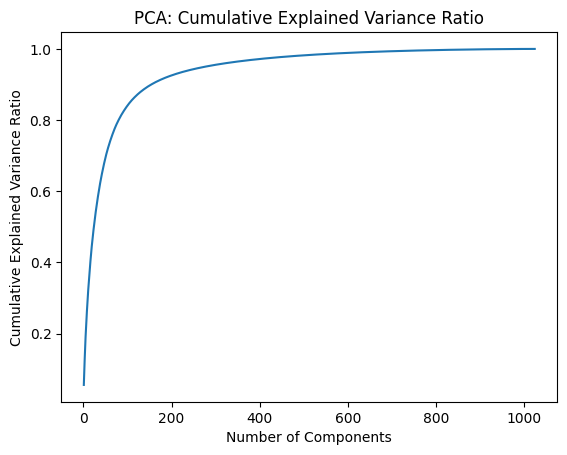

Number of components explaining 95.0% of variance: 276


100%|██████████| 4/4 [00:25<00:00,  6.39s/it]


,model,method,f1_score,accuracy
0,MiniLM_L6_v2,K-Means simple,0.363921,0.308417
1,MiniLM_L6_v2,K-Medoids_Manhattan simple,0.306894,0.261337
2,MiniLM_L6_v2,K-Medoids_Cosine simple,0.306203,0.263259
3,MiniLM_L6_v2,Spectral_Clustering_NN simple,0.383479,0.368370
4,MiniLM_L6_v2,K-Means pca,0.363921,0.308417
5,MiniLM_L6_v2,K-Medoids_Manhattan pca,0.306894,0.261337
6,MiniLM_L6_v2,K-Medoids_Cosine pca,0.306203,0.263259
7,MiniLM_L6_v2,Spectral_Clustering_NN pca,0.383479,0.368370
8,mpnet_base_v2,K-Means simple,0.428639,0.381630
9,mpnet_base_v2,K-Medoids_Manhattan simple,0.318159,0.277287


In [24]:
models = {
    'MiniLM_L6_v2' : './/data//semantic//output//embeddings//all_MiniLM_L6_v2.pkl' , 
    'mpnet_base_v2': './/data//semantic//output//embeddings//all_mpnet_base_v2.pkl' ,
    'roberta'      : './/data//semantic//output//embeddings//roberta.pkl' ,
}

primary = get_primary_category(category_file)


def evaluate(model_name, model_file, clustering_method=run_all_clustering_with_pca):
    clustering = clustering_method(model_file, category_file)
    model_list = [df['clustering'].tolist() for df in clustering.values()]
    ari, nmi = calculate_clustering_consistency(model_list)
    evaluation = {}
    eva_df = pd.DataFrame(columns=['accuracy','weighted_F1'])
    for key, value in clustering.items():
        cluster_category_mapping, accuracy, weighted_f1 = map_clustering_category(primary, value)
        evaluation[key] = cluster_category_mapping
        eva_df.loc[len(eva_df)] = [accuracy, weighted_f1]
    eva_df.index = ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN']
    return eva_df, ari, nmi



perfs = pd.DataFrame(columns=[
    'model',
    'method', 
    'f1_score', 
    'accuracy', 
    # 'ari',
    # 'nmi'
])

for model_name, model_file in models.items():
    eva, ari, nmi = evaluate(model_name, model_file, clustering_method=run_all_clustering)

    for method, row in eva.iterrows():
        new_row = pd.DataFrame({
            'model': [model_name],
            'method': [f'{method} simple'],
            'f1_score': [row['weighted_F1']],
            'accuracy': [row['accuracy']],
            # 'ari': [ari],
            # 'nmi': [nmi]
        })
        perfs = pd.concat([perfs, new_row], ignore_index=True)

    eva1, ari1, nmi1 = evaluate(model_name, model_file, clustering_method=run_all_clustering_with_pca)

    for method, row in eva1.iterrows():
        new_row = pd.DataFrame({
            'model': [model_name],
            'method': [f'{method} pca'],
            'f1_score': [row['weighted_F1']],
            'accuracy': [row['accuracy']],
            # 'ari': [ari1],
            # 'nmi': [nmi1]
        })
        perfs = pd.concat([perfs, new_row], ignore_index=True)

perfs

we can see that in this way the articles that are belong to the same category are more inclined to be clustered together.

## 2. Attention Oriented Emotion Labeling

### 2.1. HTML Content Preprocessing and Extraction with Hyperlink Preservation

This part we first extracts semantic segments from HTML files of all webpages, and define and calculate weighted emotion scores based on human reading attentioen on hyperlink and increasing sparsity.

We considered the action of \
•	Lemmatization: Reduces words to their base form (e.g., “running” to “run”). \
•	Stemming: Trims words to their root (e.g., “jumps” to “jump”).

Benefits of Lemmatization and Stemming in Sentiment Analysis

1.	Both lemmatization and stemming reduce words to a common form, which can help models by reducing vocabulary size and focusing on the base meaning of words. For instance, “amazing” and “amazingly” become “amaz,” which may help a simpler model recognize these as similar in sentiment.
2.	Reducing Noise: Variations in verb tenses or plural forms don’t usually impact sentiment. By simplifying “running,” “ran,” and “runs” to “run,” the model can better focus on the emotional content of the words rather than linguistic variations.

Drawbacks of Lemmatization and Stemming

1.	Loss of Nuance: Stemming, in particular, can lead to words losing critical distinctions. For example, “happy” and “happiness” might both be stemmed to “happi,” which removes any slight difference in meaning or intensity that could be relevant to sentiment.
2.	Complicated Sentiment Contexts: Certain suffixes can carry sentiment information. For instance, “help” (neutral) versus “helpful” (positive). Stemming might remove these subtle distinctions, potentially reducing accuracy.

However, for transformer models (e.g., BERT, RoBERTa) or when working with models trained on large datasets, as these models already account for nuanced variations. Modern models handle token variations well, and stemming can reduce performance by discarding subtle context. Therefore, lemmatization alone might be a safer choice than stemming. It preserves word meaning more accurately, while still standardizing some forms. Stemming might only be beneficial for smaller, less nuanced datasets where word reduction is crucial.

Hence, we only perform lemmatization here.

Extracts readable text from HTML content while preserving hyperlinks. The anchor tags in the HTML content will be converted to a format that includes the anchor text and URL in the form `[anchor_text](URL)`. The function splits the text into sentences to make it more aligned with natural reading behavior.

In [3]:
extract_sentences('data/wikispeedia/wpcd/wp').head(3)

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,721,722,723,724,725,726,727,728,729,730
0,Royal_Marines.htm,Royal Marines Royal Marines [ 2007 Schools Wik...,Related subject : [ Military History and War ]...,A core component of the country 's Rapid Deplo...,"The high level of training and competence , co...",The Royal Marines are a component part of the ...,Role Corps of Royal Marines Cap Badge of the R...,As the United Kingdom Armed Forces ' specialis...,In common with the other armed force the Royal...,"Command , Control and Organisation Command of ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Recycling.htm,Recycling Recycling [ 2007 Schools Wikipedia S...,Related subject : [ Environment ] ( URL ) [ ] ...,[ Environmental science ] ( URL ) Environmenta...,Recycling prevents useful material resource be...,Recycling is a key concept of modern [ waste m...,"Recyclable material , also called `` recyclabl...","They include [ glass ] ( URL ) , paper , [ alu...","Biodegradable waste , such a food waste or gar...",Recyclates need to be sorted and separated int...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Retreat_of_glaciers_since_1850.htm,Retreat of glacier since 1850 Retreat of glaci...,Related subject : [ Climate and the Weather ] ...,"Studied by glaciologists , the temporal coinci...",Mid-latitude mountain range such a the [ Himal...,The Little Ice Age wa a period from about 1550...,"Subsequently , until about 1940 glacier around...","Glacial retreat slowed and even reversed , in ...","However , since 1980 a significant global warm...",In location such a the Andes of [ South Americ...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2. Attention Span Weight Calculation

#### 2.2.1. Link Attention Modelling

First we will generate a dictionary the contains the count of each linked link corresponding with each target.

Reasoning:
> To model human attention in navigation, we hypothesize that a human navigator is likely to focus more on links or titles that are relevant to their end goal, or target article. By examining real human behavioral data, we can derive a dictionary that quantifies the frequency of articles encountered on the way to each target article. This dictionary serves as an indicator of the correlation between each intermediate link/title and the target article.

> This correlation relationship gives insight into a human's inclination to choose specific links or titles based on their relevance to the target. In other words, the more frequently an article appears in paths leading to a particular target, the more likely it reflects a natural inclination or preference in human navigation behavior. The unclicked links will share the same ambigutious / preassumed inclination.

In [4]:
generate_link_freq_dict('data/wikispeedia/wikispeedia_paths-and-graph/paths_finished.tsv')

{'African_slave_trade': {'14th_century': 2,'Europe': 3,'Africa': 16,'Atlantic_slave_trade': 18, ......}


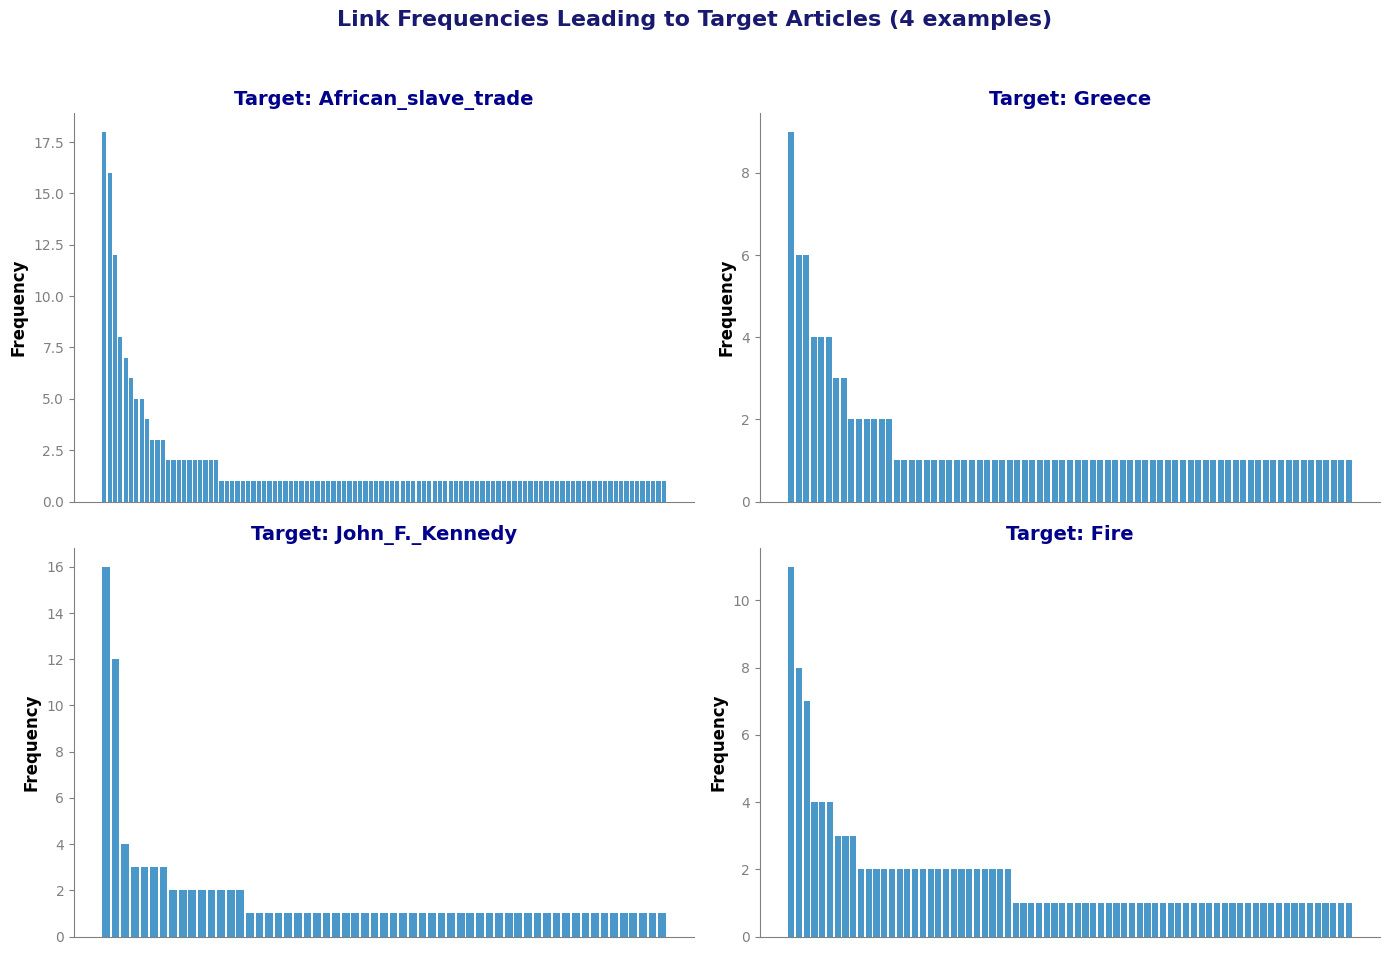

In [5]:
plot_link_frequencies('data/emotion/link_freq_dict.json')

Exponential Distribution of Frequencies: 
 
In each target’s subplot, the frequencies of articles leading to the target display an exponential-like property: a small number of articles have high frequencies, while most other articles appear less frequently. This indicates that users tend to follow a few common paths when navigating to a target, suggesting a strong preference for specific links that are likely perceived as highly relevant to the end goal.

#### 2.2.2. Sentence Weight Assignment

To model user attention, we assume that users are more likely to focus on links within sentences, as these links serve as potential pathways to reach their target. Therefore, sentences containing links (`[ anchor_text ] ( URL )`) are assigned relatively higher weights than those without links, which share a baseline weight.

In addition, we use link click frequency as an indicator of the attention drawn by each link. Links that have been clicked more frequently are likely to be perceived as more relevant or interesting, indicating a higher level of attention from users. Consequently, the weight for each link is proportional to its click frequency, and links with higher click frequencies are assigned greater weights than those with no recorded clicks.

The weight assignment method is formalised as following:

> Mathematical Expression for Sentence Weight Assignment

To model sentence weight based on link presence and click frequency, we define the following:

1. Let $S$ be a sentence.
2. Let $L_i$ represent each link in sentence $S$, where $i = 1, 2, \ldots, n$ (if there are $n$ links in the sentence).
3. Let $f(L_i)$ denote the click frequency of link $L_i$.
4. Let $W_{baseline}$ represent the baseline weight assigned to sentences with no links.

> Weight Assignment Formula

The weight $W(S)$ for sentence $S$ is assigned as follows:

1. **If $S$ contains no links**, assign a baseline weight:
   $$
   W(S) = W_{\text{baseline}}
   $$

2. **If $S$ contains links**, the weight of $S$ is calculated based on a normalized sum of the click frequencies for the links in $S$:
   $$
   W(S) = W_{\text{baseline}} + k \cdot \sum_{i=1}^n \frac{f(L_i)}{\text{\#links for target}}
   $$
   where:
   - $W_{\text{baseline}}$ is the baseline weight for sentences without links.
   - $k$ is a proportionality constant that scales the contribution of click frequency to the overall sentence weight.
   - $f(L_i)$ represents the click frequency of link $L_i$.
   - $\text{\#links for target}$ is the total sum of click frequencies for all links leading to the specified target.


> Explanation of the Formula

- **Baseline Weight $W_{\text{baseline}}$**: Ensures that every sentence has a minimum weight, even if it contains no links.
- **Click Frequency Contribution**: The term $\sum_{i=1}^n k \cdot f(L_i)$ increases the weight for sentences containing links based on how frequently those links are clicked. The higher the frequency $f(L_i)$ for a link, the greater the weight for the sentence, reflecting increased user attention.
- **Normalization Term $\frac{f(L_i)}{\text{\#links for target}}$**: Each link’s frequency $f(L_i)$ is divided by the total click frequency for the target, ensuring that frequencies are comparable across targets with varying link counts.
- **Scaled Contribution**: The normalized click frequencies are scaled by $k$ and summed for each link in the sentence, providing an overall attention weight that reflects user focus based on link relevance and frequency.


This formula prioritizes sentences with high-frequency links, aligning with the assumption that frequently clicked links draw more user attention.

Relevant literature that justifies the choice above: 
> Kahneman, D. (1973). Attention and Effort. Prentice-Hall. This classic work emphasizes that attention is a limited resource and is selectively allocated to elements that are most informative or engaging.

Proportionality Constant ( $k$ ): This value ensures that while links with high click frequencies (popular or frequently chosen links) increase sentence weight significantly, the scaling remains moderate to reflect that human attention, even when selectively focused, tends to spread across multiple cues rather than concentrating exclusively on a single feature.

> Treisman, A. M., & Gelade, G. (1980). A feature-integration theory of attention. Cognitive Psychology, 12(1), 97-136. This study suggests that attention is directed based on feature saliency, but that it distributes across multiple features, particularly in complex tasks.

#### 2.2.3. Handling Backtracking in Path Analysis: Considerations for Emotional Analysis

In analyzing navigation paths, we must consider how to handle backtracking steps (represented by `<`). Backtracking occurs when users navigate back to a previous article, which can provide valuable insights into their exploratory behavior but may also introduce noise. Here, we explore two approaches: **removing backtracking** and **replacing backtracking with the previous article**. Each approach has unique implications for emotional analysis and the relationship between emotion change and semantic distance.

##### 1. Removing Backtracking
In this approach, all instances of `<` are removed from the path, resulting in a streamlined path sequence without backtracking steps.

**Pros**:
- **Cleaner Path Sequence**: Removing backtracking provides a straightforward path, showing only forward progression. This is beneficial when the focus is on direct associations between consecutive articles.
- **Simplified Emotional Analysis**: Without backtracking, emotional analysis can focus purely on the progression of emotions as users encounter new topics. This can make patterns in emotion change easier to identify and analyze.

**Cons**:
- **Loss of Exploration Behavior**: By removing backtracking, we lose information about the user’s exploratory behavior, which might be relevant to understanding emotional responses to content revisitation.
- **Potential Loss of Emotional Nuance**: Backtracking could indicate repeated exposure to emotionally charged topics. Without it, we might miss certain patterns in emotional reactions tied to revisiting previously encountered topics.

##### 2. Replacing Backtracking with the Previous Article
In this approach, each `<` is replaced with the last visited article, effectively duplicating articles in the path to indicate when users revisit content.

**Pros**:
- **Insight into Exploratory Patterns**: This approach preserves the user’s backtracking behavior, which may reveal exploratory or confirmatory patterns. These patterns could indicate deeper engagement with certain topics or themes.
- **Enhanced Emotional Analysis**: Repeated articles in the path allow us to track emotional responses to revisited content, which might reflect sustained or heightened emotions. For example, revisiting a topic with strong emotional content could amplify or stabilize the user’s emotional state.

**Cons**:
- **Increased Path Complexity**: Backtracking introduces additional steps in the path, which could complicate the analysis by increasing the number of steps and potentially diluting clear patterns in emotional progression.
- **Potential Noise in Emotional Trends**: If users frequently backtrack to neutral or less significant content, it could introduce noise in emotional trends, making it harder to distinguish meaningful emotional changes.

##### Relationship Between Emotion Change and Semantic Distance

The choice between removing or preserving backtracking also impacts the analysis of **emotion change in relation to semantic distance** between articles:
- **Removing Backtracking** emphasizes the semantic distance between new topics, allowing us to examine how emotional responses shift with each novel topic encountered.
- **Preserving Backtracking** captures both semantic proximity (revisiting the same topic) and changes over time, allowing for a more detailed study of how repeated exposure to specific content influences emotion.

By analyzing emotion change in conjunction with semantic distance, we can assess how users’ emotions evolve as they navigate through increasingly different (or similar) topics. This approach could reveal patterns such as emotional intensification with greater semantic distance or stabilization with repeated exposure.

In summary, each approach offers unique insights, and the best choice depends on the focus of the analysis:
- **Without Backtracking** is ideal for studying direct emotional progression across diverse topics.
- **With Backtracking** is suitable for understanding how emotional responses are influenced by topic revisitation and exploratory behavior.

In [6]:
path_df_no_backtracking = extract_path_data('dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='remove')
path_df_with_backtracking = extract_path_data('dataset/wikispeedia_paths-and-graph/paths_finished.tsv', handle_backtracking='replace')

Paths have been extracted and saved to dataset/extracted_paths_no_backtracking.csv
Paths have been extracted and saved to dataset/extracted_paths_with_backtracking.csv


#### 2.2.4. Weighted Emotion Scores

Now that each sentence has an associated emotion label, we can calculate a weighted emotion score for each sentence. This score combines the previously calculated attention weight of the sentence with its emotion label, providing a more nuanced view of the emotional significance based on user attention.

Let:
- $W(S)$ be the attention weight of sentence $S$, calculated as described previously.
- $E(S)$ be the emotion label (or emotion score) associated with sentence $S$.

The weighted emotion score for each sentence $S$ is calculated as:
$$
\text{E}_{weighted}(S) = W(S) \cdot E(S)
$$

This weighted emotion score provides a refined measure that accounts for both the emotional tone of the sentence and the likelihood that it will capture attention.

#### 2.2.5. Increasing Reading Sparsity: Nested Macro Average 

To account for the nature of reading sparsity, we will calculate a **Nested Macro Average** of weighted emotion scores by progressively grouping sentences. This approach reflects the likelihood that readers pay more attention to earlier sentences and progressively less to later sections.

##### Grouping Structure for Nested Macro Average

The weighted emotion scores are grouped as follows:
1. The first sentence alone: $[1]$
2. The second and third sentences together: $[2, 3]$
3. The fourth, fifth, and sixth sentences together: $[4, 5, 6]$
4. The seventh through tenth sentences together: $[7, 8, 9, 10]$
5. Continue grouping in this nested manner, with each subsequent group containing one additional sentence.

##### Steps for Calculating the Nested Macro Average

1. **Calculate the Weighted Emotion for Each Group**: For each group, calculate the average weighted emotion score within the group.
   
2. **Average the Grouped Scores**: After calculating the average for each group, take the average of these grouped scores to obtain the final Nested Macro Average.


Let:
- $W\_E(S_i)$ represent the weighted emotion score of sentence $S_i$.
- Groups are defined as $G_1 = [S_1]$, $G_2 = [S_2, S_3]$, $G_3 = [S_4, S_5, S_6]$, $G_4 = [S_7, S_8, S_9, S_{10}]$, and so forth, with each subsequent group expanding by one additional sentence.

The **Nested Macro Average** is calculated as:
$$
\text{Nested Macro Average} = \frac{1}{k} \sum_{j=1}^k \left( \frac{\sum_{i \in G_j} W\_E(S_i)}{|G_j|} \right)
$$
where:
- $k$ is the total number of groups,
- $G_j$ is the $j$-th group of sentences,
- $|G_j|$ is the number of sentences in group $G_j$,
- $\sum_{i \in G_j} W\_E(S_i)$ represents the sum of weighted emotions within group $G_j$.

This formula averages the weighted emotions within each group and then takes the overall average across groups. By weighting the earlier sentences more heavily, this approach provides a balanced measure that reflects both the emotional tone and the attentional distribution across the article.

In [7]:
# Define file paths
unweighted_emotion = 'data/emotion/unweighted_emotion_article.csv'                 # Replace with the actual path for the first CSV
paths_nonbacktracking = 'data/emotion/extracted_paths_no_backtracking.csv' # Replace with the actual path for the no-backtracking CSV
paths_backtracking = 'data/emotion/extracted_paths_with_backtracking.csv' # Replace with the actual path for the backtracking CSV
click_frequencies = 'data/emotion/link_freq_dict.json' # Replace with the actual path for the click frequencies JSON
# Load the CSV files into DataFrames
unweighted_emotion = pd.read_csv(unweighted_emotion)
paths_backtracking = pd.read_csv(paths_backtracking)
paths_nonbacktracking = pd.read_csv(paths_nonbacktracking)
sentences = pd.read_csv('data/emotion/extracted_sentences.csv', index_col=0)
sentences.index = sentences.index.map(lambda x: re.split(r'\.html?$', str(x))[0] if isinstance(x, str) else x) # cases such as U.S._state.htm can be dealed correctly.


we have the emotion annotation (24 types) that consider both human attention span and reading sparsity for each article in each navigation path for each path. And here is an example for one path and one emotion.

In [8]:
# Test the function with a single path
first_row = paths_backtracking.iloc[0]
target = first_row['target']
path = first_row.drop(labels=['target']).dropna().tolist()

# Calculate the weighted emotions for this single path for the 'surprise' emotion
weighted_path_df = calculate_weighted_emotion_for_single_path(path, target, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise')

print(weighted_path_df)

# Display the target and path
print("Target:", target)
print("Path:", path)

                target    Step_1    Step_2    Step_3    Step_4    Step_5  \
0  African_slave_trade  0.000339  0.000287  0.000306  0.000208  0.000251   

     Step_6    Step_7    Step_8  
0  0.000211  0.000292  0.000272  
Target: African_slave_trade
Path: ['14th_century', '15th_century', '16th_century', 'Pacific_Ocean', 'Atlantic_Ocean', 'Accra', 'Africa', 'Atlantic_slave_trade']


### 2.3 Result showcase

Now we can do the calculation through all emotions on all paths. And here we only consider backtracking paths. (We will do non-backtracking for milestone)
But for the milestone 2 we only proceed on two emotions: 'surprise' and 'curiosity' for our further discussion

In [9]:
process_backtracking_paths(paths_backtracking, unweighted_emotion, sentences, click_frequencies, emotion_type='surprise') # Emotion score on every step of every path, with backtracking on surprise emotion.
process_backtracking_paths(paths_backtracking, unweighted_emotion, sentences, click_frequencies, emotion_type='curiosity') # Emotion score on every step of every path, with backtracking on curiosity emotion.

Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_surprise.csv'
Weighted emotions for each step in all paths have been calculated and saved to 'dataset/backtracking_path_weighted_emotions_curiosity.csv'


In [10]:
backtracking_path_weighted_emotions_surprise_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_surprise.csv')
backtracking_path_weighted_emotions_curiosity_df = pd.read_csv('data/emotion/backtracking_path_weighted_emotions_curiosity.csv')
backtracking_path_weighted_emotions_surprise_df = backtracking_path_weighted_emotions_surprise_df.drop(columns=['path_index'])
backtracking_path_weighted_emotions_curiosity_df = backtracking_path_weighted_emotions_curiosity_df.drop(columns=['path_index'])

In [11]:
backtracking_path_weighted_emotions_surprise_df.head() # Display the DataFrame for surprise emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000339,0.000287,0.000306,0.000208,0.000251,0.000211,0.000292,0.000272,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000339,0.000246,0.000292,0.000272,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000339,0.000291,0.000337,0.000289,0.000186,0.000292,0.000272,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000339,0.000340,0.000444,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000339,0.000317,0.000207,0.000355,0.000519,0.000233,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
backtracking_path_weighted_emotions_curiosity_df.head() # Display the DataFrame for curiosity emotion

,target,Step_1,Step_2,Step_3,Step_4,Step_5,Step_6,Step_7,Step_8,Step_9,...,Step_425,Step_426,Step_427,Step_428,Step_429,Step_430,Step_431,Step_432,Step_433,Step_434
0,African_slave_trade,0.000352,0.000296,0.000285,0.000333,0.000385,0.000250,0.000424,0.000651,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,African_slave_trade,0.000352,0.000489,0.000424,0.000651,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,African_slave_trade,0.000352,0.000311,0.000629,0.000245,0.000740,0.000424,0.000651,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Greece,0.000352,0.000881,0.000252,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,John_F._Kennedy,0.000352,0.000277,0.000401,0.001415,0.000479,0.000511,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Analyze Semantic Distance and Emotion Scores for Correlation

### 3.1. Emotion Scores with Steps

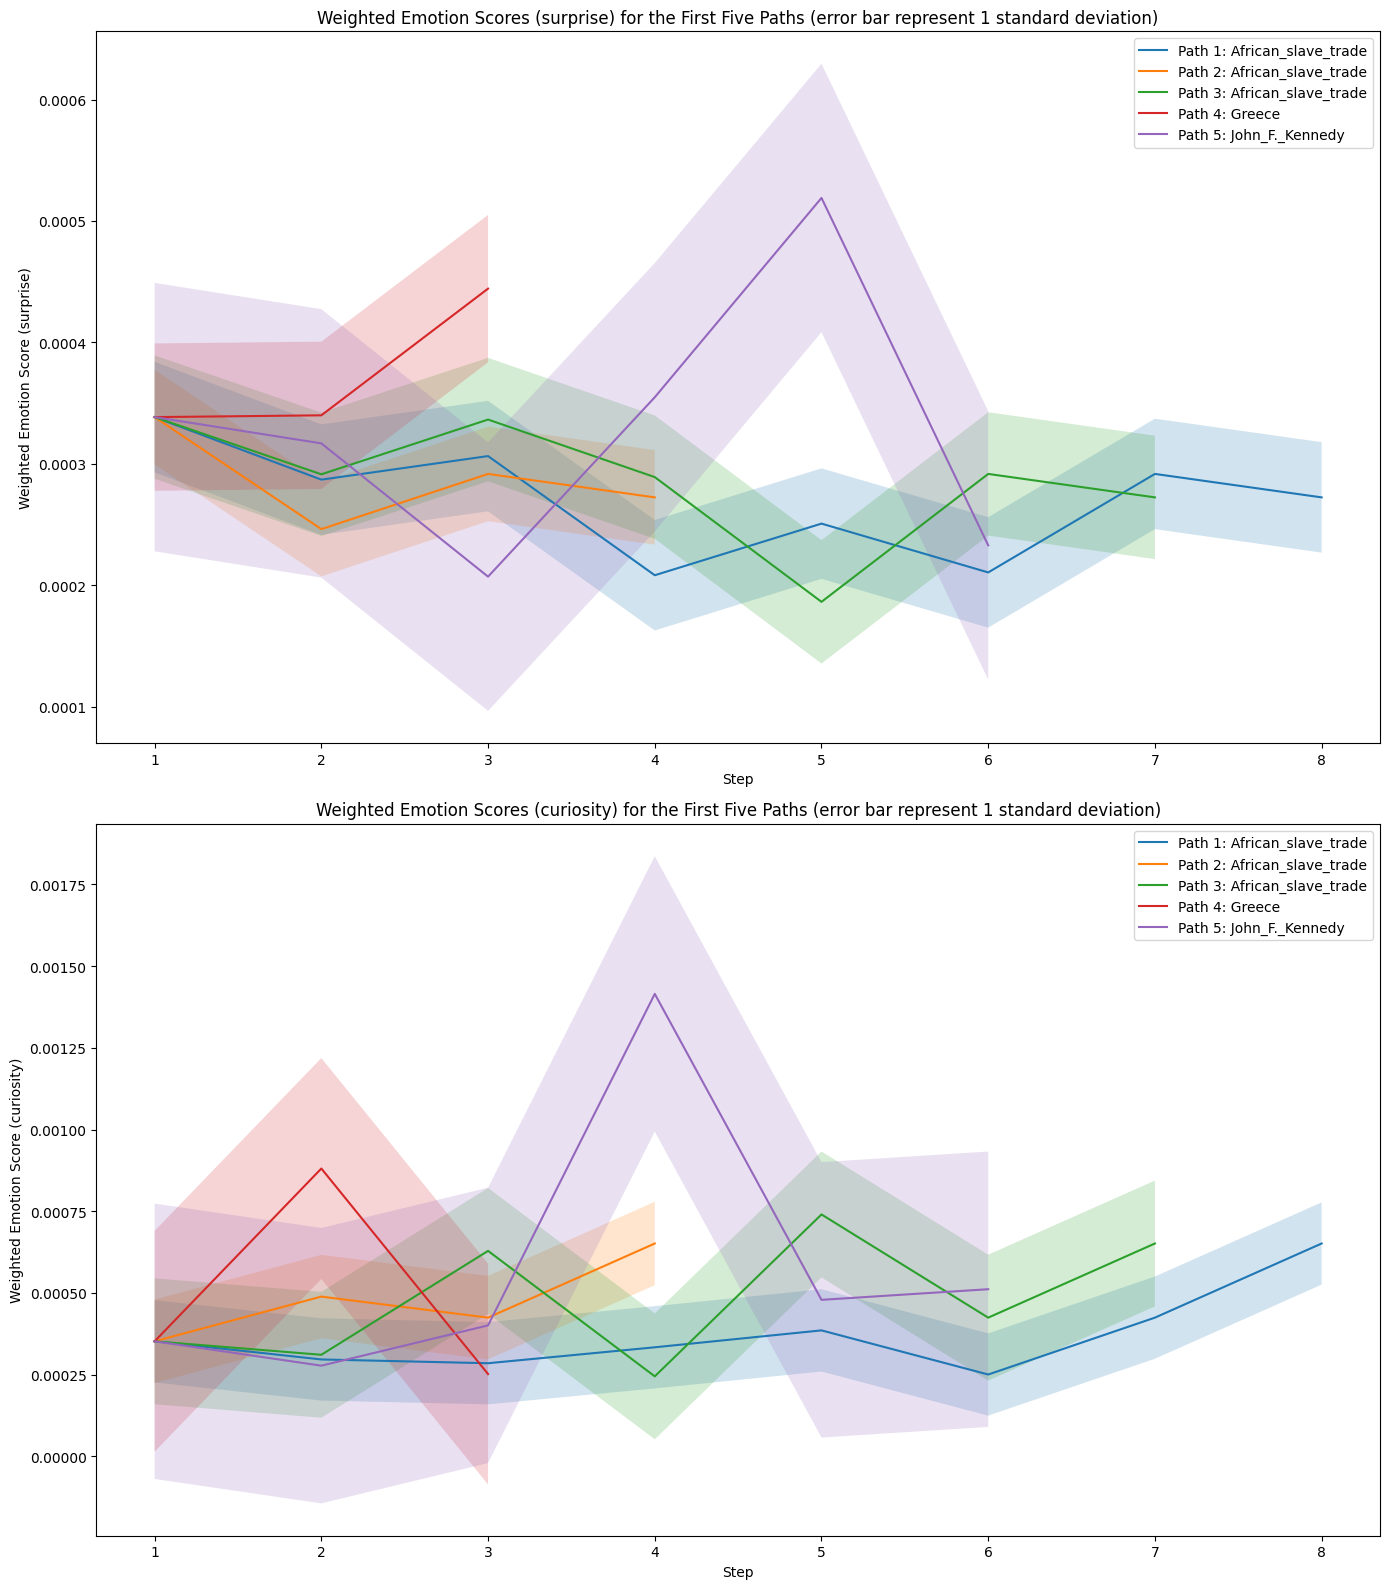

In [13]:
first_five_paths_surprise = backtracking_path_weighted_emotions_surprise_df.head(5)
first_five_paths_curiosity = backtracking_path_weighted_emotions_curiosity_df.head(5)
# Plotting both emotions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))

# Plot for Surprise
plot_emotion_paths(ax1, first_five_paths_surprise, 'surprise')

# Plot for Curiosity
plot_emotion_paths(ax2, first_five_paths_curiosity, 'curiosity')

# Show the plots
plt.tight_layout()
plt.show()

### 3.2. Visulization 2 Correlation of Two Emotions

In [14]:
# Create a list to store the correlation results
correlation_data = []

# Iterate over each path and calculate the correlation
for path_index in backtracking_path_weighted_emotions_surprise_df.index:
    correlation, p_value = calculate_emotion_correlation(path_index, backtracking_path_weighted_emotions_surprise_df, backtracking_path_weighted_emotions_curiosity_df)
    num_steps = backtracking_path_weighted_emotions_surprise_df.loc[path_index].drop(labels=['target']).dropna().shape[0]
    
    if correlation is not None:  # Only add rows with valid correlation values
        correlation_data.append({'path_index': path_index, 'correlation': correlation, 'p_value': p_value, 'num_steps': num_steps})

# Convert the list of dictionaries to a DataFrame
correlation_df = pd.DataFrame(correlation_data)

# Calculate the mean and variance of the correlation column
mean_correlation = correlation_df['correlation'].mean()
variance_correlation = correlation_df['correlation'].var()

print("Correlation DataFrame:")
print(correlation_df.head())
print("\nMean Correlation:", mean_correlation)
print("Variance of Correlation:", variance_correlation)

# Print p-values as well
print("\nP-Values:")
print(correlation_df['p_value'].mean())


Correlation DataFrame:
   path_index  correlation   p_value  num_steps
0           0     0.132568  0.754332          8
1           1    -0.651501  0.348499          4
2           2    -0.501131  0.251924          7
3           3    -0.613398  0.579604          3
4           4     0.138638  0.793375          6

Mean Correlation: 0.1349301121490291
Variance of Correlation: 0.3303757638465521

P-Values:
0.517746353919295
